**PROJECT REPORT**

**Predicting Heart Disease Based on Cholesterol and Max Heart Rate**

Matt Ward, Byeori Kim, Seifeldin Elkemary, Chaitanya Thakral

**INTRODUCTION** (needs to be improved)

Heart disease, also known as cardiovascular disease, is a prevalent and potentially life-threatening condition that affects the heart and blood vessels. There are several types of heart diseases such as: heart failure, arrhythmias, valvular heart disease, and coronary artery disease, being the most common out of the four. The earlier the diagnosis of these diseases, the better the treatment becomes. Hence, our goal of this project is to be able to classify new patients on their likelihood of having a heart disease based on several risk factors that play into the possibility.

**Can we determine if a new patient is at risk of heart disease based on their age, cholesterol level, resting blood pressure, and presence of chest pain?**


This question will be addressed using a dataset from Cleveland, since it has the variables of the risk factors that play in diagnosing a heart disease. The dataset has age(years), cholesterol levels(mg/dl),  resting blood pressure(mmHg), and presence of chest pain in its data of many instances of patients. 


**Preliminary Exploratory Data Analysis**

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
# setting the seed for reproducibility
set.seed(4)
# importing the data
cleveland_data<-read_csv("https://raw.githubusercontent.com/byuly/dsci-100-group-project/main/processed.cleveland.data",
                col_names = c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"))


#converting ? to NAs 
cleveland_data[cleveland_data =="?"]<-NA

# cleaning the data, wrangling names 
cleveland_tidy<-cleveland_data|>
                    mutate(diagnosis=ifelse(is.na(num),NA,(num > 0)))|>
                    mutate(sex= as.factor(sex),cp= as.factor(cp), fbs= as.factor(fbs),restecg= as.factor(restecg),exang= as.factor(exang),thal= as.factor(thal),ca= as.factor(ca),slope= as.factor(slope), diagnosis=as.factor(diagnosis))|>
                    mutate(sex= fct_recode(sex,"M" = "1", "F" = "0"))|>
                    mutate(cp= fct_recode(cp,"Typical Angina"="1", "Atypical Angina"="2","Non-Anginal Pain"="3","Asymptomatic"="4")) |>
                    select(-num)

# splitting the original dataset in a ratio of 75/25 
cleveland_split<-initial_split(cleveland_tidy,prop = 0.75, strata = diagnosis)
cleveland_training<-training(cleveland_split)
cleveland_testing<-testing(cleveland_split)
                

# preview of the training dataset
head(cleveland_training)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,M,Typical Angina,145,233,1,2,150,0,2.3,3,0.0,6.0,FALSE
37,M,Non-Anginal Pain,130,250,0,0,187,0,3.5,3,0.0,3.0,FALSE
41,F,Atypical Angina,130,204,0,2,172,0,1.4,1,0.0,3.0,FALSE
57,F,Asymptomatic,120,354,0,0,163,1,0.6,1,0.0,3.0,FALSE
56,F,Atypical Angina,140,294,0,2,153,0,1.3,2,0.0,3.0,FALSE
44,M,Atypical Angina,120,263,0,0,173,0,0.0,1,0.0,7.0,FALSE


**Using "diagnosis" instead of "num"**

We found out that the "num" column is unbalanced. Meaning 54% of the values were 0 the other 46% were the values: 1, 2, 3, and 4. So, combining "num" values greater than 0 to "TRUE" and 0 values to "FALSE" to make it more readable and an easier classification problem since we are only prediction two diagnosis now. Not to mention, it improves readability to determine whether or not a patient has heart disease no matter it's severity.

# we are treating this as a classification problem, and num also has discrete levels so using diagnosis is more readable than using different levels 

Limitation to add at the end: 1. USing classification over regression is not the best there is a grey area itt sint balck or white 
2. we need more info to make it a regression probelm 
3. Important to say thet the accuracy isnt the best measure 
4. Also we need to mention at what stage of the severity to do correct measure rather than hvaing true and false values

In [3]:
# Creating a table summarizing important information about our variables used
cleveland_summary<-cleveland_training|>
                     group_by(diagnosis) |>
                     summarize(min_age = min(age), max_age = max(age), mean_age = mean(age),
                              min_chol = min(chol), max_chol = max(chol), mean_chol = mean(chol),
                              min_trestbps = min(trestbps), max_trestbps = max(trestbps), mean_trestbps = mean(trestbps),
                              patients = n())
cleveland_summary

diagnosis,min_age,max_age,mean_age,min_chol,max_chol,mean_chol,min_trestbps,max_trestbps,mean_trestbps,patients
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,34,76,51.99187,126,564,243.4634,94,180,129.4309,123
TRUE,35,77,56.52885,131,409,249.9712,100,200,134.0673,104


In [4]:
#plotting the training data
resting_age_plot <- ggplot(cleveland_training, aes(x = age, y = trestbps, color = diagnosis)) +
                 geom_point(stat= "identity") +
                  labs(x = "Age (years)", y = "Resting Blood Pressure (mm Hg)", color = "Diagnosis")  +
                 scale_fill_brewer("Set2")
cholestrol_age_plot <- ggplot(cleveland_training, aes(x = age, y = chol, color = diagnosis)) +
                 geom_point(stat= "identity") +
                  labs(x = "Age (years)", y = "Cholesterol (mg/dl)", color = "Diagnosis")  +
                 scale_fill_brewer("Set2")

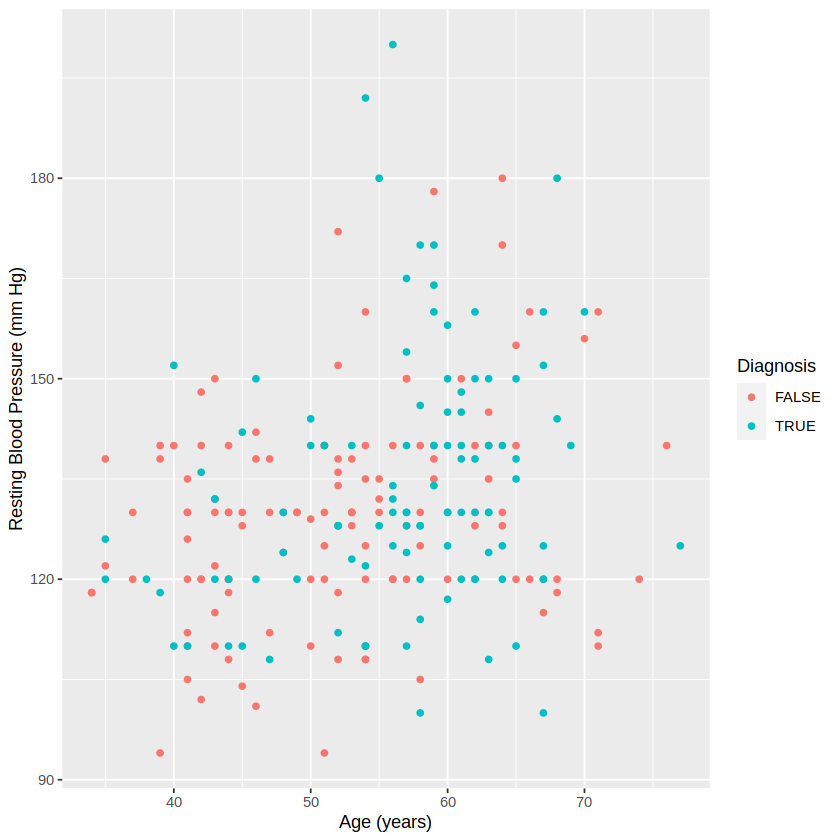

In [5]:
resting_age_plot

FIRST GRAPH EXPLANATION

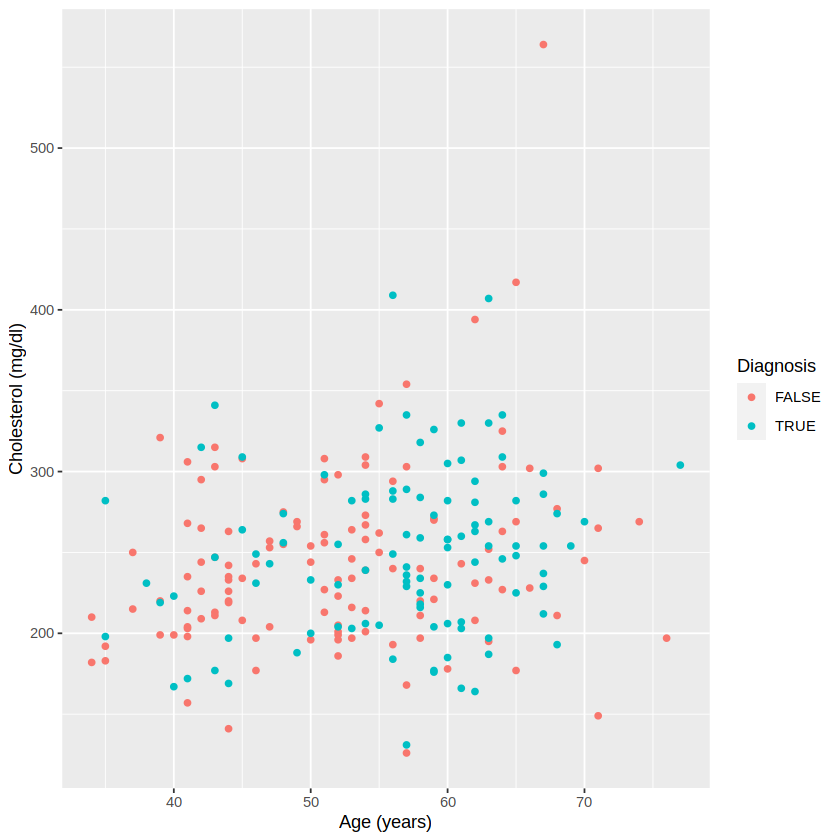

In [6]:
cholestrol_age_plot

SECOND GRAPH EXPLANATION

**METHODS**

To predict whether a patient is afflicted with heart disease of not, we chose to use the "processed.cleveland.data" file from the Heart Disease Database

When diagnosing heart diseases, the key factors considered include the patient's age, chest pain, cholesterol levels, and resting blood pressure. We opted to employ them as classifiers for our prediction model, since according to multiple studies, these are the best indicators available in the dataset for predicting heart disease.

The data was tidied, and since it included occurrences of "?" in place of missing data, they were substituted with NA. A new column “diagnosis” was created to assign “TRUE” for any value above 0 in the column “num"

While building the classification model, we first split the data into training and test sets.In order to ensure that we assess the performance of our method on observations not seen during training.The dataset was split into a 75:25 ratio (training set: testing set), and the  seed was set with set.seed(4) for reproducibility in any random processed in our code.

To facilitate a thorough analysis, we computed the minimum and maximum age, cholesterol, and resting blood pressure

We opted to represent our data visually by using a bar graph and scatterplots. For example, a bar graph was generated to illustrate the relationship between the number of patients and different categorical chest pain types.

We will perform a $K$-nearest neighbors classification, using tidymodels, thus we split 75% of the data into training datasets, and the remaining 25% into testing datasets to utilize sufficient data to build accurate models (Timbers et al., 2022). 
To conduct our analysis, we will  “scale and center our data” (Timbers et al., 2022) to create a model (Timbers et al., 2022). This requires cross-validation to determine each dataset’s optimal $K$, then our model will be fit to the testing data to classify the patients by diagnosis (Timbers et al., 2022). Our goal is to determine the most accurate model, evaluating the metrics and confusion matrix for each (Timbers et al., 2022). To visualize our results we will create a bar plot denoting the number of correct/incorrect predictions in the testing dataset for each model to determine their accuracy.

**EXPECTED OUTCOMES AND SIGNIFICANCE**

From our analysis, we expect to find correlations between age, cholesterol levels, chest pain, and resting blood levels with the presence of an individual having heart disease. Additionally, we want to be able to anticipate key factors that contribute to the likelihood of heart disease in a patient.

These findings could have significant implications for early detection and prevention of heart disease.

Given ample time, a thorough and in-depth analysis of the following questions could be explored.
       
        1. What additional factors not considered in this analysis might also be relevant to predicting heart disease?
        2. How can technology and machine learning be further leveraged to enhance predictive models?


In [7]:
# Creating the recipe 
knn_recipe<-recipe(diagnosis~ thalach + chol, data = cleveland_training) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

# Creating the model specification
knn_tune<-nearest_neighbor(weight_func = "rectangular",neighbors = tune())|>
   set_engine("kknn") |>
   set_mode("classification")

# Perform 10 fold-cross valdiation
knn_vfold <- vfold_cv(cleveland_training ,v =10, strata=diagnosis)

grid_vals<-tibble(neighbors=c(1:100))

# Create workflow
knn_results <- workflow() |>
      add_recipe(knn_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples =knn_vfold , grid = grid_vals) |>
# Collect metrics, filter for accuracy
      collect_metrics()|>
      filter(.metric=="accuracy")|>
      select(neighbors,mean)|>
      arrange(desc(mean))

head(knn_results)

neighbors,mean
<int>,<dbl>
85,0.7021245
86,0.7021245
79,0.6894433
80,0.6894433
73,0.6892457
74,0.6892457


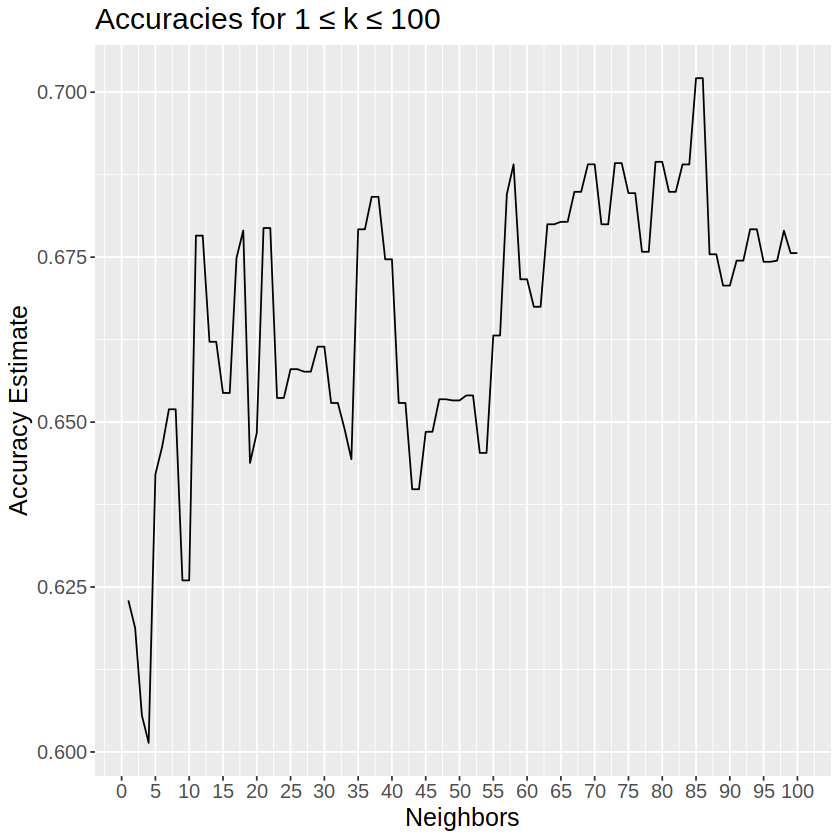

In [8]:
# Visualizing the accuracy vs neighbors graph
accuracy_graph<-ggplot(knn_results,aes(x = neighbors, y = mean))+
      geom_line() + 
      xlab("Neighbors")+ 
      ylab("Accuracy Estimate")+ 
      labs(title = "Accuracies for 1 ≤ k ≤ 100") + 
      scale_x_continuous(breaks = seq(0, 100, by = 5)) + 
      theme(text = element_text(size = 15)) 

accuracy_graph

In [9]:
#Evaluating the accuracy of classifier in comparison to majority classifier.
cleveland_proportions <- cleveland_training |>
    group_by(diagnosis) |> 
    summarize(n=n()) |> 
    mutate(percent = 100*n/nrow(cleveland_training))

cleveland_proportions

diagnosis,n,percent
<fct>,<int>,<dbl>
FALSE,123,54.18502
TRUE,104,45.81498


In [10]:
# Building the final model
set.seed(1)


final_knn_model <- nearest_neighbor(weight_func="rectangular", neighbors = 85)|>
    set_engine("kknn") |>
    set_mode("classification")


fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(final_knn_model) |>
    fit(data = cleveland_training)

fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(85,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3171806
Best kernel: rectangular
Best k: 85